### Question 7.1
>Describe a situation or problem from your job, everyday life, current events, etc., for which exponential smoothing would be appropriate. What data would you need? Would you expect the value of α (the first smoothing parameter) to be closer to 0 or 1, and why?

One obvious application of exponential smoothing from my most recent job is using it to better predict budgets. I was responsible for managing the budget of three seperate secondary schools and would have to provide a 5 year projected budget every year. Using an exponential smoothing model on the overall budget as well as the different setions of the budget would provide a more accurate estimation of future costs andcapture trends and seasonality which would be insightful. Things like cost of supplies or building costs have trends (overall increasing year over year...) and seasonality components (energy costs during the winter/summer for example). We kept monthly budget data that could be used to train the model for forecasting purposes so the frequency of the seasonality would be 12. Each month was broken down by the various categories and I would imagine both an overall budget model that used the lumped data from all the categories, as well as a model that used the data from each individual category to provide insight into those line items.  I think an α value closer to 1 would be used as expenses are tightly controlled and monitored so their isn't much randomness in the data, and both revenues and expenses are fairly consistent month over month once trend and seasonality are considered.

### Question 7.2
>Using the 20 years of daily high temperature data for Atlanta (July through October) from Question 6.2 (file temps.txt), build and use an exponential smoothing model to help make a judgment of whether the unofficial end of summer has gotten later over the 20 years. (Part of the point of this assignment is for you to think about how you might use exponential smoothing to answer this question. Feel free to combine it with other models if you’d like to. There’s certainly more than one reasonable approach.) 
Note: in R, you can use either HoltWinters (simpler to use) or the smooth package’s es function (harder to use, but more general). If you use es, the Holt-Winters model uses model=”AAM” in the function call (the first and second constants are used “A”dditively, and the third (seasonality) is used “M”ultiplicatively; the documentation doesn’t make that clear)

To look if the end of unofficial summer has gotten later for Atlanta I am going to use the HoltWinters model. I started by trying to get a better understanding of how the model worked and found this resource really helpful: https://orangematter.solarwinds.com/2019/12/15/holt-winters-forecasting-simplified/. 

1) Review the Data
2) Apply a 1st, 2nd, and 3rd order Holt Winters model to the data
3) Analyze the models to see if trend and seasonality play a role
4) Use the CUSUM method on seasonality to determine the unofficial end of summer is changing

In [26]:
# Load libraries needed for analysis
library(outliers)
library(pastecs)
library(ggplot2)
library(tidyverse)
library(forecast)
library(tseries)
library(lubridate)
library(tidyr)

#### Step 1 - Review the Data
The first thing I want to do is take a look at the data, while it has already been explored in the previous homework I am going to include it here to make this a standalone document.

In [2]:
# Load the data
temps_data <- read.table("temps.txt", header = TRUE)

In [3]:
# Look at the data, only displaying the first 6 rows for this report
head(temps_data)

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
1-Jul,98,86,91,84,89,84,90,73,82,...,93,95,85,95,87,92,105,82,90,85
2-Jul,97,90,88,82,91,87,90,81,81,...,93,85,87,90,84,94,93,85,93,87
3-Jul,97,93,91,87,93,87,87,87,86,...,93,82,91,89,83,95,99,76,87,79
4-Jul,90,91,91,88,95,84,89,86,88,...,91,86,90,91,85,92,98,77,84,85
5-Jul,89,84,91,90,96,86,93,80,90,...,90,88,88,80,88,90,100,83,86,84
6-Jul,93,84,89,91,96,87,93,84,90,...,81,87,82,87,89,90,98,83,87,84


In [4]:
# Look at the data types
t(sapply(temps_data, class))

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
factor,integer,integer,integer,integer,integer,integer,integer,integer,integer,...,integer,integer,integer,integer,integer,integer,integer,integer,integer,integer


In [5]:
# Double check size of the data
cat('Rows',' ','Columns')
t(dim(temps_data))

Rows   Columns

123,21


In [6]:
# Check for missing values
sapply(temps_data, anyNA)

DAY X1996 X1997 X1998 X1999 X2000 X2001 X2002 X2003 X2004 X2005 X2006 X2007 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
X2008 X2009 X2010 X2011 X2012 X2013 X2014 X2015 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [7]:
# Get statistical information about each column
stat.desc(temps_data)

,DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
nbr.val,NA,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,...,1.230000e+02,1.230000e+02,1.230000e+02,123.0000000,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02
nbr.null,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nbr.na,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,NA,6.000000e+01,5.500000e+01,6.300000e+01,5.700000e+01,5.500000e+01,5.100000e+01,5.700000e+01,5.700000e+01,6.200000e+01,...,5.300000e+01,5.900000e+01,5.000000e+01,51.0000000,6.700000e+01,5.900000e+01,5.600000e+01,5.600000e+01,6.300000e+01,5.600000e+01
max,NA,9.900000e+01,9.500000e+01,9.500000e+01,9.900000e+01,1.010000e+02,9.300000e+01,9.700000e+01,9.100000e+01,9.500000e+01,...,9.800000e+01,1.040000e+02,9.500000e+01,95.0000000,9.700000e+01,9.900000e+01,1.050000e+02,9.200000e+01,9.500000e+01,9.700000e+01
range,NA,3.900000e+01,4.000000e+01,3.200000e+01,4.200000e+01,4.600000e+01,4.200000e+01,4.000000e+01,3.400000e+01,3.300000e+01,...,4.500000e+01,4.500000e+01,4.500000e+01,44.0000000,3.000000e+01,4.000000e+01,4.900000e+01,3.600000e+01,3.200000e+01,4.100000e+01
sum,NA,1.029700e+04,1.004600e+04,1.036400e+04,1.025300e+04,1.033600e+04,1.003100e+04,1.028100e+04,1.002200e+04,1.005700e+04,...,1.021500e+04,1.050400e+04,1.014900e+04,9962.0000000,1.072700e+04,1.048900e+04,1.041200e+04,1.004500e+04,1.032500e+04,1.024600e+04
median,NA,8.400000e+01,8.400000e+01,8.600000e+01,8.600000e+01,8.600000e+01,8.400000e+01,8.700000e+01,8.400000e+01,8.200000e+01,...,8.500000e+01,8.600000e+01,8.500000e+01,83.0000000,9.000000e+01,8.900000e+01,8.500000e+01,8.400000e+01,8.600000e+01,8.500000e+01
mean,NA,8.371545e+01,8.167480e+01,8.426016e+01,8.335772e+01,8.403252e+01,8.155285e+01,8.358537e+01,8.147967e+01,8.176423e+01,...,8.304878e+01,8.539837e+01,8.251220e+01,80.9918699,8.721138e+01,8.527642e+01,8.465041e+01,8.166667e+01,8.394309e+01,8.330081e+01
SE.mean,NA,7.707778e-01,8.402680e-01,5.779084e-01,8.767230e-01,8.582715e-01,7.415797e-01,8.499223e-01,6.327873e-01,6.007771e-01,...,8.830639e-01,8.145141e-01,7.874436e-01,0.8126922,6.713072e-01,8.954623e-01,8.342578e-01,6.966788e-01,5.943334e-01,7.852885e-01


This lets me know that I have a table with 123 rows and 21 columns. The data is primarily integers with one factor value which is the DAY column. Temperature ranges for each year are ~30-40 degrees and the standard deviations are ~6.5-10. The data represents the daily high temperature in Atlanta for the given year from July through October. The last thing I'm going to do is create a time series object from the data and look at the data over the entire time period.

In [8]:
# Create table of dates and temperatures for later reference
temps_unpacked <- temps_data %>%
  gather(key = "Year", value = "Temperature", -DAY) %>%
  mutate(Date = dmy(paste(DAY, Year, sep = "-")),
         Date = format(Date, "%b %e, %Y")) %>%
  select(Date, Temperature)

# Display the head of the new data
head(temps_unpacked)

Date,Temperature
"Jul 1, 1996",98
"Jul 2, 1996",97
"Jul 3, 1996",97
"Jul 4, 1996",90
"Jul 5, 1996",89
"Jul 6, 1996",93


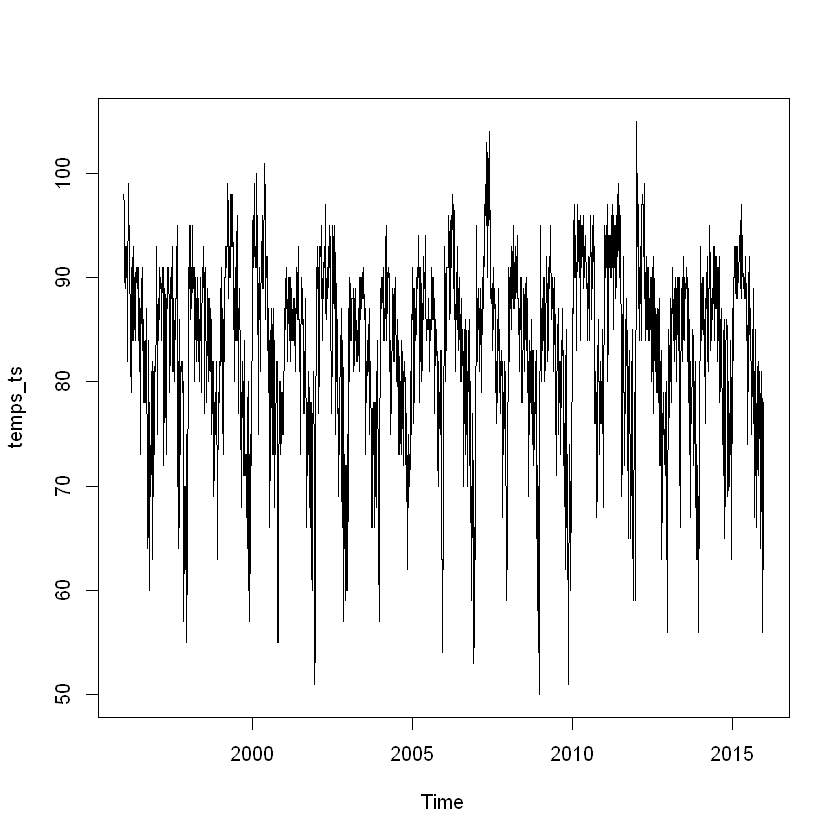

In [9]:
# Create a time series object
temps_ts <- ts(as.vector(unlist(temps_data[, 2:21])), start = 1996, frequency = 123)

# Plot the time series
plot.ts(temps_ts)

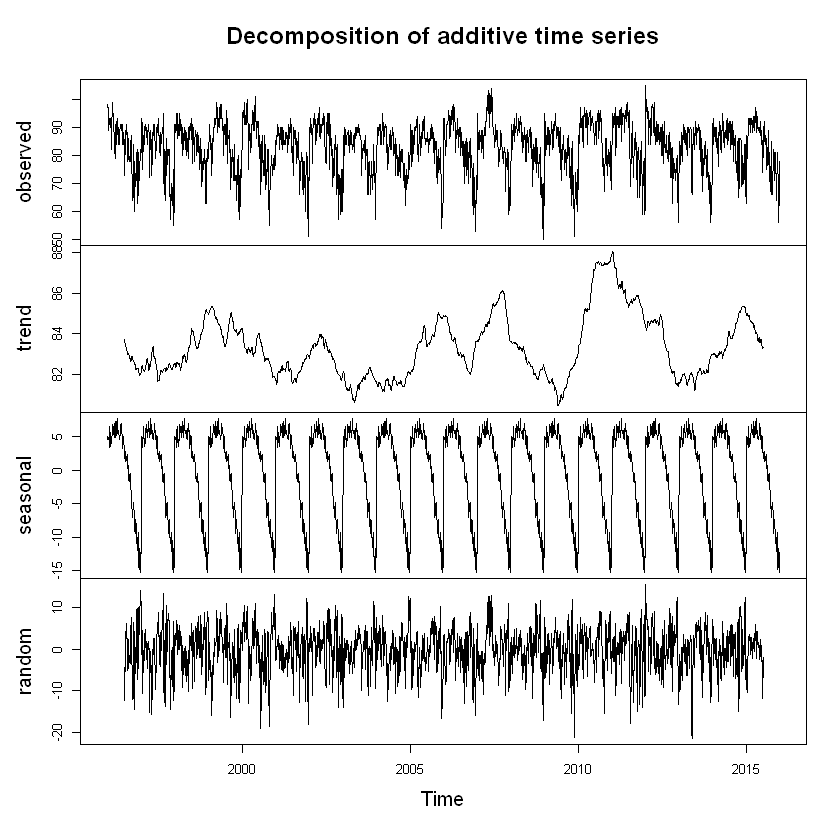

In [10]:
# Finally I want to look at the components of the time series data
components_temps_ts <- decompose(temps_ts)
plot(components_temps_ts)

When looking at the various components of the time series data it's important to look at the scale of the vertical axis for each component. While it shows a clear seasonality pattern that follows the general seasons of our data the random factor is actually more influential. It will be interesting to see how the exponential model compares.

#### Step 2 - Apply a 1st, 2nd, and 3rd order Holt Winters model to the data
Now that I've looked at the data and prepared it for the Holt Winters model I am goign to create four models: single, double, and triple exponential smoothing with additive and multiplicative seasonality.

In [11]:
# Create four models: single, double, triple with additive seasonality, and triple w/ multiplicative seasonality exponential smoothing
temps_hw_1 <- HoltWinters(temps_ts, alpha=NULL, beta=FALSE, gamma=FALSE)
temps_hw_2 <- HoltWinters(temps_ts, alpha=NULL, beta=NULL, gamma=FALSE)
temps_hw_3_add <- HoltWinters(temps_ts, alpha=NULL, beta=NULL, gamma=NULL) 
temps_hw_3_mult <- HoltWinters(temps_ts, alpha=NULL, beta=NULL, gamma=NULL, seasonal = "mult") 

In [12]:
# Look at the output for the single exponential model
temps_hw_1

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = temps_ts, alpha = NULL, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.8388021
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 63.30952

In [13]:
# Look at output for double exponential model
temps_hw_2

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = temps_ts, alpha = NULL, beta = NULL, gamma = FALSE)

Smoothing parameters:
 alpha: 0.8445729
 beta : 0.003720884
 gamma: FALSE

Coefficients:
        [,1]
a 63.2530022
b -0.0729933

In [14]:
# Look at output for triple exponential mode using the additive method
temps_hw_3_add

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = temps_ts, alpha = NULL, beta = NULL, gamma = NULL)

Smoothing parameters:
 alpha: 0.6610618
 beta : 0
 gamma: 0.6248076

Coefficients:
              [,1]
a     71.477236414
b     -0.004362918
s1    18.590169842
s2    17.803098732
s3    12.204442890
s4    13.233948865
s5    12.957258705
s6    11.525341233
s7    10.854441534
s8    10.199632666
s9     8.694767348
s10    5.983076192
s11    3.123493477
s12    4.698228193
s13    2.730023168
s14    2.995935818
s15    1.714600919
s16    2.486701224
s17    6.382595268
s18    5.081837636
s19    7.571432660
s20    6.165047647
s21    9.560458487
s22    9.700133847
s23    8.808383245
s24    8.505505527
s25    7.406809208
s26    6.839204571
s27    6.368261304
s28    6.382080380
s29    4.552058253
s30    6.877476437
s31    4.823330209
s32    4.931885957
s33    7.109879628
s34    6.178469084
s35    4.886891317
s36    3.890547248
s37    2.148316257
s38

In [15]:
# Look at output for triple exponential mode using the multiplicative method
temps_hw_3_mult

Holt-Winters exponential smoothing with trend and multiplicative seasonal component.

Call:
HoltWinters(x = temps_ts, alpha = NULL, beta = NULL, gamma = NULL,     seasonal = "mult")

Smoothing parameters:
 alpha: 0.615003
 beta : 0
 gamma: 0.5495256

Coefficients:
             [,1]
a    73.679517064
b    -0.004362918
s1    1.239022317
s2    1.234344062
s3    1.159509551
s4    1.175247483
s5    1.171344196
s6    1.151038408
s7    1.139383104
s8    1.130484528
s9    1.110487514
s10   1.076242879
s11   1.041044609
s12   1.058139281
s13   1.032496529
s14   1.036257448
s15   1.019348815
s16   1.026754142
s17   1.071170378
s18   1.054819556
s19   1.084397734
s20   1.064605879
s21   1.109827336
s22   1.112670130
s23   1.103970506
s24   1.102771209
s25   1.091264692
s26   1.084518342
s27   1.077914660
s28   1.077696145
s29   1.053788854
s30   1.079454300
s31   1.053481186
s32   1.054023885
s33   1.078221405
s34   1.070145761
s35   1.054891375
s36   1.044587771
s37   1.023285461
s38   1.0258367

In [16]:
nrow(fitted(temps_hw_1))

[1] 2459

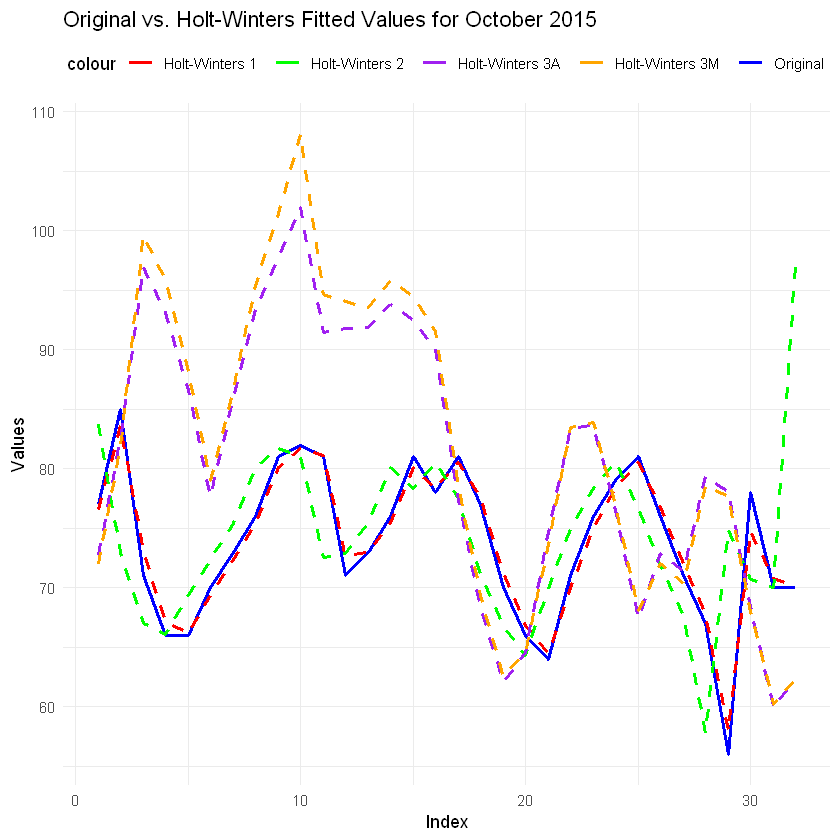

In [17]:
# Since the graphs are hard to interpret at the larger scale I'm going to zoom in on just one month (Oct. 2015) and plot all four models
# Extract fitted values for the specified range
fitted_values_1 <- fitted(temps_hw_1)[2428:2459]
fitted_values_2 <- fitted(temps_hw_2)[2428:2459]
fitted_values_3 <- fitted(temps_hw_3_add)[2428:2459]
fitted_values_4 <- fitted(temps_hw_3_mult)[2428:2459]

# Create a new dataframe
temps_ts_plot <- data.frame(
  index = 1:length(fitted_values_1),
  original = as.numeric(temps_ts[2428:2459]),
  hw_1 = as.numeric(fitted_values_1),
  hw_2 = as.numeric(fitted_values_2),
  hw_3 = as.numeric(fitted_values_3),
  hw_4 = as.numeric(fitted_values_4)
)

ggplot(temps_ts_plot, aes(x = index)) +
  geom_line(aes(y = original, color = "Original"), linetype = "solid", size = 1) +
  geom_line(aes(y = hw_1, color = "Holt-Winters 1"), linetype = "dashed", size = 1) +
  geom_line(aes(y = hw_2, color = "Holt-Winters 2"), linetype = "dashed", size = 1) +
  geom_line(aes(y = hw_3, color = "Holt-Winters 3A"), linetype = "dashed", size = 1) +
  geom_line(aes(y = hw_4, color = "Holt-Winters 3M"), linetype = "dashed", size = 1) +
  labs(x = "Index", y = "Values", title = "Original vs. Holt-Winters Fitted Values for October 2015") +
  theme_minimal() +
  theme(legend.position = "top") +
  scale_color_manual(values = c("Original" = "blue", "Holt-Winters 1" = "red", "Holt-Winters 2" = "green", "Holt-Winters 3A" = "purple", "Holt-Winters 3M" = "orange")) +
  scale_linetype_manual(values = c("Original" = "solid", "Holt-Winters 1" = "dashed", "Holt-Winters 2" = "dashed", "Holt-Winters 3A" = "dashed", "Holt-Winters 3M" = "dashed")) +
  scale_size_manual(values = rep(1, 5))

#### Step 3 - Analyze the models to see if trend and seasonality play a role
Now that the models have been created I am going to look at which model has produced the best results, as well as the trend and seasonality values to see if their is an overall trend in the temperatures data.

In [18]:
# Get the final sum of squared errors achieved in optimizing each model
cat("The SSE for single exponential smoothing model:", temps_hw_1$SSE)
cat("\n")
cat("The SSE for double exponential smoothing model:", temps_hw_2$SSE)
cat("\n")
cat("The SSE for triple exponential smoothing model using additive seasonality:", temps_hw_3_add$SSE)
cat("\n")
cat("The SSE for triple exponential smoothing model using multiplitive seasonality:", temps_hw_3_mult$SSE)

The SSE for single exponential smoothing model: 56198.1
The SSE for double exponential smoothing model: 56572.54
The SSE for triple exponential smoothing model using additive seasonality: 66244.25
The SSE for triple exponential smoothing model using multiplitive seasonality: 68904.57

Interestingly enough **the single exponential smoothing model seems to match the original dataset the best and has the smallest Sum of Squared Errors value**. When comparing both triple exponenential smoothing models, using additive seasonality seems to produce slightly better results in terms of the Sum of Squared Errors value.

In [19]:
# Output the model beta coefficients and final b value for hw_2, hw_3_add, and hw_3_mult
cat("The beta value for the double exponential smoothing model is:",temps_hw_2$beta, "and the final b value is:",temps_hw_2$coefficients['b'])
cat("\n")
cat("The beta value for the triple exponential smoothing model using multiplicative seasonality is:",temps_hw_3_mult$beta, "and the final b value is:",temps_hw_3_mult$coefficients['b'])
cat("\n")
cat("The beta value for the triple exponential smoothing model using additive seasonality is:",temps_hw_3_add$beta, "and the final b value is:",temps_hw_3_mult$coefficients['b'])
cat("\n")

The beta value for the double exponential smoothing model is: 0.003720884 and the final b value is: -0.0729933
The beta value for the triple exponential smoothing model using multiplicative seasonality is: 0 and the final b value is: -0.004362918
The beta value for the triple exponential smoothing model using additive seasonality is: 0 and the final b value is: -0.004362918


The trend values shown above (final trend estimate b and the beta value) are very small indicating that **their is not a strong trend showing a change in temperature over time.**

#### Step 4 - Apply the CUSUM model to the seasonality values
The last thing I am going to do is to apply the CUSUM model to the seasonality values from the triple exponential smoothing model. I want to see if the seasonality value is changing year over year which could indicate a change in when summer is ending. I am going to use the additive seasonality model as it had the lower Sum of Squared Errors value indicating that it fit the data slightly better. To get a better sense of the different components of the additive seasonality model I am going to start by ploting them.

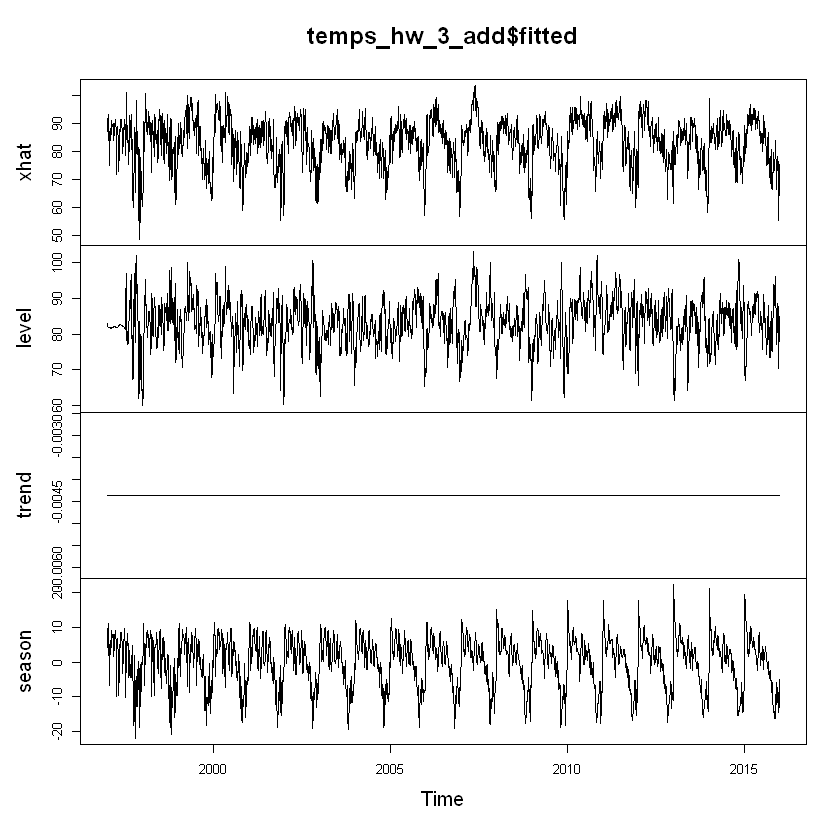

In [20]:
# Plot the additive seasonality triple exponential smoothing model
plot(temps_hw_3_add$fitted)

Looking at the graph above the first thing I notice is that the trend value is very, very small (~ -0.0045) which is what I expected based on the output of the previous models. Next, looking at the seasonality factor it does seem to change slightly over time, with the minimum values (~ -20) occuring in the first few years and the maximum values (~20) occuring in the last few years. It will be interesting to see if the CUSUM model shows this as being significant. Next I'll pull the seasonality values from the Holt-Winters model and prepare it for the CUSUM model. I am going to create a dataframe with the day for each row and a column for each year with the corresponding seasonality values in it.

In [21]:
# Create dataframe similar to previous homework but with Seasonality values instead of temperatures
seasonality_df <- data.frame(Day = temps_data$DAY, matrix(temps_hw_3_add$fitted[,4], ncol = 19))

# Add Column names
new_column_names <- c("Day", "X1997", "X1998", "X1999", "X2000", "X2001", "X2002", "X2003", "X2004", "X2005", "X2006", "X2007", "X2008", "X2009", "X2010", "X2011", "X2012", "X2013", "X2014", "X2015")
colnames(seasonality_df) <- new_column_names

# Check new dataframe
head(seasonality_df)

Day,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,X2005,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
1-Jul,4.303159,4.054077,9.349191,8.130519,9.261932,8.532675,10.833750,10.596553,9.559008,9.526730,12.454249,15.18901,15.052357,17.963213,17.946705,17.796582,22.385105,21.31072,19.45438
2-Jul,8.238119,8.168393,8.457426,7.810603,8.686298,9.197265,9.837370,11.663073,10.874704,10.162519,11.021049,10.13469,11.583196,12.246533,12.817176,14.277046,14.037278,16.07719,17.19256
3-Jul,11.091777,11.100059,11.213419,11.470326,11.416575,11.012491,10.210645,12.021948,12.738520,11.468041,11.483482,10.45074,11.722773,11.707197,11.803979,12.726046,14.244787,12.98723,12.74993
4-Jul,9.042997,9.057058,9.529053,10.185524,10.863856,10.209557,10.532285,10.867244,11.779117,11.552601,11.117308,11.69283,11.650082,12.084663,12.461996,12.000781,12.458283,12.62307,11.98537
5-Jul,2.067387,2.067912,3.708913,5.588420,7.004562,8.024549,9.444664,8.518818,9.749682,10.738920,10.552850,11.29192,10.939712,8.908885,10.345553,10.214813,11.172561,12.77225,12.94898
6-Jul,2.116168,2.106939,2.232254,3.394700,4.340175,5.462823,6.487578,7.648008,8.250531,7.421824,6.156207,7.12694,6.619883,8.329696,9.151988,9.361362,9.444097,10.35325,11.13812


For the T and C values I am going to set them as factors of the standard deviation for the first month of data

In [22]:
column_stdev <- apply(seasonality_df[,2:ncol(seasonality_df)], 2, sd)
average_sd <- mean(column_stdev)

C <- 0.5 * average_sd
T <- 50
cat("The C value is:",C)

The C value is: 3.569673

Next I am going to create a new dataframe to store the CUSUM values and then loop through each column (year) and save the calculated CUSUM values to the dataframe. I am going to use the mean of the first month for the mu value for each year similar to HW 6.2 and since I am looking for when the seasonality value starts to decrease I am using the CUSUM equation that subtracts the seasonality and C value from the mean.

In [23]:
# Create cusum_df, will start with values from seasonality so it has the right dimensions but will replace all the values as I go
cusum_df <- seasonality_df

# Loop through each column in the dataframe except for the first column that contains the date
for (j in 2:ncol(cusum_df)) {
    year_mean <- mean(seasonality_df[1:31, j]) # Using July for the mean Seasonality value
    for (i in 1:nrow(cusum_df)) {
        if (i == 1) {                          # Make sure that the previous value is 0 for the first iteration
            previous_value <- 0
        } else {
            previous_value <- cusum_df[i-1, j]
        }
        cusum_df[i, j] <- pmax(0, previous_value + (year_mean - C - seasonality_df[i, j])) # Calculate the CUSUM value and save it to the df
        }
    }

# I want to take a look at the dataframe, note that the first values are during summer and have a positive seasonality so are all showing 0
head(cusum_df)

Day,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,X2005,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
1-Jul,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2-Jul,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-Jul,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4-Jul,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5-Jul,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6-Jul,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next I am going to plot the CUSUM value for each year to see the general trend and compare it to the set threshold value T

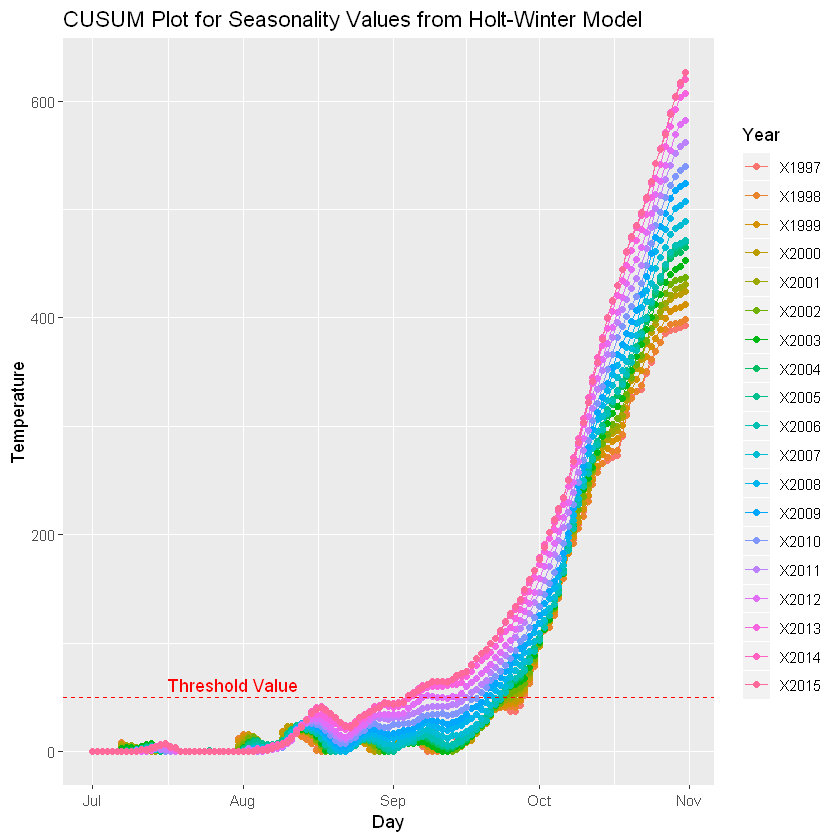

In [24]:
# Reshape the data into long format for plotting
cusum_df_long <- gather(cusum_df, key = "Year", value = "Temperature", -Day)

# Convert Day column to Date type
cusum_df_long$Day <- as.Date(cusum_df_long$Day, format = "%d-%b")

# Plot the data
ggplot(data = cusum_df_long, aes(x = Day, y = Temperature, color = Year)) +
  geom_line() +
  geom_point() +
  ggtitle("CUSUM Plot for Seasonality Values from Holt-Winter Model") +
  geom_hline(yintercept = T, linetype = "dashed", color = "red") +
  scale_color_discrete(name = "Year") +
  annotate("text", x = as.Date("2024-07-30"),  y = T+25, label = "Threshold Value", vjust = 1.5, color = "red")

Lastly, I am going to create a new dataframe that has the index of the row where each year crosses the threshold value and plot those values. The index corresponds to the number of days from July 1st where the threshold value is crossed.

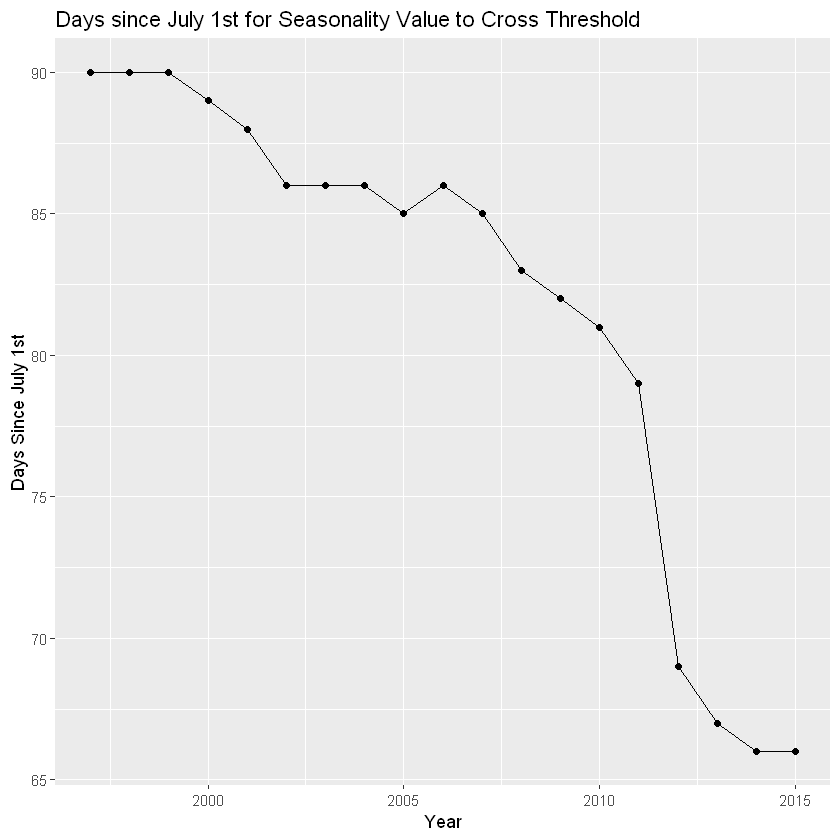

In [25]:
# Create dataframe to store index values
output_df <- data.frame(Year = 1997:2015, days_past = 0)

# Loop through each year and find the index of when the threshold value is crossed
for (j in 1:19) {
    crossed_value_index <- min(which(cusum_df[,j+1] >= T))
    output_df$days_past[j] = crossed_value_index
    }

# Plot the # of days from July 1st to when the index value is crossed for each year
ggplot(data = output_df, aes(x = Year, y= days_past)) +
  geom_line() +
  geom_point() +
  ylab("Days Since July 1st") +
  ggtitle("Days since July 1st for Seasonality Value to Cross Threshold")

What the graph above shows is that the seasonality value does seem to decrease sooner (less days since July 1st) as time goes on which would indicate that summer is ending later. However, this can easily be flipped by changing the C value I use. If I use a C value of 0.75 * sd then the days from July 1st hardly change year over year, if I use a C value of 1 * sd it shows the seasonality value actually changing later as time goes on. Without more context about the problem, and more data to analyze, **I can't draw a conlusion regarding the end of summer shifting over time.**